<a href="https://colab.research.google.com/github/hk-97/eht-imaging/blob/master/rotatationtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pycm livelossplot
%pylab inline
!pip install albumentations
!pip install -U git+https://github.com/albu/albumentations

     |████████████████████████████████| 51kB 1.4MB/s 
     |████████████████████████████████| 491kB 5.7MB/s 
     |████████████████████████████████| 215kB 43.8MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 634kB 2.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Clo

## Additional Functions


In [0]:
# creates a 'progress bar' when loading data
# |-----------------#####|

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 50%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from IPython.display import HTML, display
import time


from albumentations import (
   HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
   Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
   IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
   IAASharpen, IAAEmboss, Flip, OneOf, Compose, Normalize, GaussianBlur, Rotate, RandomCrop
)

def set_seed(seed):
  """
  Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
  torch.backends.cudnn.enabled   = False

  return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
  print("Cuda installed! Running on GPU!")
  device = 'cuda'
else:
  print("No GPU available!")

Cuda installed! Running on GPU!


In [0]:
from getpass import getpass
import os

user = getpass('github user')
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-convolution

github user··········
github password··········
fatal: destination path 'acse-8-miniproject-convolution' already exists and is not an empty directory.


In [0]:
pwd

'/content'

In [0]:
%cd 'drive/My Drive/acse-8-miniproject-convolution'

/content/drive/My Drive/acse-8-miniproject-convolution


In [0]:
train_labels = np.load('Data/kmnist-train-labels.npy')
train_imgs   = np.load('Data/kmnist-train-imgs.npy')
test_imgs    = np.load('Data/kmnist-test-imgs.npy')
# test2_imgs   = np.load('Data/kmnist-test-imgs.npz')['arr_0']
# test2_labels = np.load('Data/kmnist-test-labels.npz')['arr_0']

In [0]:
print("Shape of train_labels", np.shape(train_labels))
print("Shape of train_imgs", np.shape(train_imgs))
print("Shape of test_imgs", np.shape(test_imgs))

Shape of train_labels (60000,)
Shape of train_imgs (60000, 28, 28)
Shape of test_imgs (10000, 28, 28)


In [0]:
# fig, axarray = plt.subplots(5,5, figsize=(10,10))


# for i, ax in enumerate(axarray.flatten()):
#     ax.imshow(train_imgs[i])
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_title(train_labels[i])


## Models

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()

  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)


In [0]:
class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet, self).__init__()
  
    #self.up = nn.Upsample(scale_factor=3, mode='bilinear')
    self.b1 = nn.BatchNorm2d(num_features=32)
    self.b2 = nn.BatchNorm2d(num_features=64)
    self.b3 = nn.BatchNorm2d(num_features=128)
    self.b4 = nn.BatchNorm2d(num_features=256)
    self.b5 = nn.BatchNorm2d(num_features=256)
    self.b6 = nn.BatchNorm1d(num_features=128)
    self.c1 = nn.Conv2d(1, 32, kernel_size=7, padding=0, stride=1)
    self.s1 = nn.MaxPool2d(kernel_size=4, padding=0, stride=2)
    self.c2 = nn.Conv2d(32, 64, kernel_size=4, padding=2, stride=1)
    self.s2 = nn.MaxPool2d(kernel_size=3, padding=0, stride=2)
    self.c3 = nn.Conv2d(64, 128, kernel_size=5, padding=2, stride=1)
    self.c4 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)
    self.c5 = nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1)
    self.s3 = nn.MaxPool2d(kernel_size=3, padding=0, stride=2)
  
    #self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.act = nn.ReLU()
    self.d = nn.Dropout()
    self.f1 = nn.Linear(1024, 128)
    #self.f2 = nn.Linear(512, 64)
    self.f3 = nn.Linear(128, 10)
  
  def forward(self, x):
    x = self.act(self.b1(self.c1(x)))
    
    x = self.s1(x)
    x = self.act(self.b2(self.c2(x)))
    x = self.s2(x)
    x = self.act(self.b3(self.c3(x)))
    x = self.act(self.b4(self.c4(x)))
    x = self.act(self.b5(self.c5(x)))
    x = self.s3(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    #x = self.d(x)
    x = self.act(self.b6(self.f1(x)))
    #x = self.d(x)
    #x = self.act(self.f2(x))
    #x = self.d(x)
    x = self.f3(x)
    return x

In [0]:
def apply_normalization(X):
  X = X/ 255.
  
  mu = np.mean(X)
  sig = np.std(X)

  #X = X -  mu
  #X = X/ sig
  return mu, sig

In [0]:
def train(model, optimizer, criterion, data_loader):
  model.train()
  train_loss, train_accuracy = 0, 0
  for X, y in data_loader:
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    a2 = model(X.view(-1, 1, 28, 28))
    loss = criterion(a2, y)
    loss.backward()
    train_loss += loss*X.size(0)
    y_pred = F.log_softmax(a2, dim=1).max(1)[1]
    train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
    optimizer.step()

  return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
  model.eval()
  validation_loss, validation_accuracy = 0., 0.
  for X, y in data_loader:
    with torch.no_grad():
      X, y = X.to(device), y.to(device)
      a2 = model(X.view(-1, 1, 28, 28))
      #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
      loss = criterion(a2, y)
      validation_loss += loss*X.size(0)
      y_pred = F.log_softmax(a2, dim=1).max(1)[1]
      validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

  return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
  model.eval()
  ys, y_preds = [], []
  for X, y in data_loader:
    with torch.no_grad():
      X, y = X.to(device), y.to(device)
      a2 = model(X.view(-1, 1, 28, 28))
      #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
      y_pred = F.log_softmax(a2, dim=1).max(1)[1]
      ys.append(y.cpu().numpy())
      y_preds.append(y_pred.cpu().numpy())

  return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [0]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 50
kfold = KFold(n_splits=5, shuffle = False, random_state= 42)

In [0]:
#for train2, val in kfold.split(train_imgs):
#    print(train_labels[train2].shape)

In [0]:

#   HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
#   Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
#   IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
#   IAASharpen, IAAEmboss, Flip, OneOf, Compose, Normalize, GaussianBlur

#from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage, ColorJitter, RandomChoice, RandomAffine
from torch.utils.data import Dataset

class CustomImageTensorDataset(Dataset):
  def __init__(self, data, targets, mu, sig):
    """
    Args:
        data (Tensor): A tensor containing the data e.g. images
        targets (Tensor): A tensor containing all the labels
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.data = data
    self.targets = targets
    self.mu = mu
    self.sig = sig
#     self.transform = transform
    

  def __len__(self):
    return len(self.data)
  
  
  def transforms(self):

    transforms_ = Compose([
    Normalize(mean=(self.mu), std=(self.sig)),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=1, border_mode=1),
    ], p=0.9)

    return transforms_

    
      
  
  def __getitem__(self, idx):
    sample, label = self.data[idx], self.targets[idx]
    #plt.imshow(sample)
    #plt.show()


    transformation = self.transforms()
    sample = transformation(image=sample.numpy())['image']
    #plt.imshow(sample)
      
    return sample, label

  
  

In [0]:
def train_model(momentum, X_train, X_val):
  set_seed(seed)
  model = AlexNet().to(device)#VAE().to(device)#AlexNet().to(device)#LeNet5().to(device)#VAE().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()

  liveloss = PlotLosses()
  for epoch in range(n_epochs):
    print(epoch)
    logs = {}
    
    mu_train, sig_train = apply_normalization(X_train)
    mu_val, sig_val = apply_normalization(X_val)


    kuz_train = CustomImageTensorDataset(torch.Tensor(X_train).float(), torch.Tensor(y_train).long(), mu_train, sig_train)
    kuz_val = CustomImageTensorDataset(torch.Tensor(X_val).float(), torch.Tensor(y_val).long(), mu_val, sig_val)

    train_loader = DataLoader(kuz_train, batch_size=batch_size, shuffle=False, num_workers=0)
    validation_loader = DataLoader(kuz_val, batch_size=test_batch_size, shuffle=False, num_workers=0)

    #test_loader = DataLoader(kuz_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
    
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
  
  print("Avg. Train Accuracy: ", train_accuracy.item())
  print("Avg. Validation Accuracy: ", validation_accuracy.item())
  
  return model, train_accuracy.item(), validation_accuracy.item(), liveloss

#model = train_model(0.5)

In [0]:
def test_one_filter(testimg, testlbl):
  mu, sig = apply_normalization(testimg)
  print(mu, sig)
  CITD =CustomImageTensorDataset(torch.Tensor(testimg).float(), torch.Tensor(testlbl).long(), mu, sig)#, transform=train_transform)

  CITD_ldr = DataLoader(CITD, batch_size=1, shuffle=False, num_workers=0)

  for i, [X,y] in enumerate(CITD_ldr):
    if i < 1:
      print("h")
      
      
test_one_filter(train_imgs[666:667], train_labels[666:667])

0.17096338535414168 0.3359245617228445
h


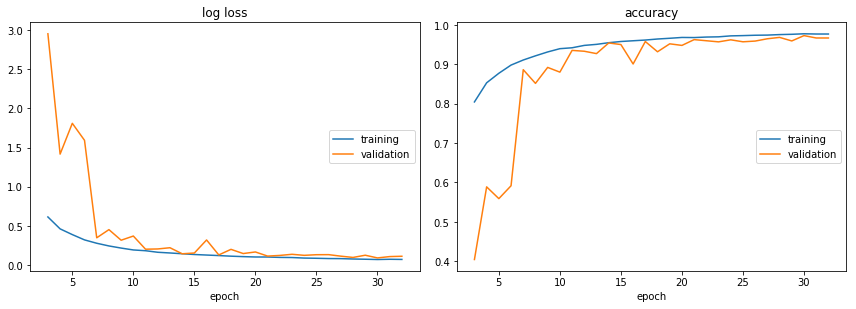

log loss:
training   (min:    0.072, max:    1.738, cur:    0.073)
validation (min:    0.092, max:    2.951, cur:    0.113)

accuracy:
training   (min:    0.406, max:    0.977, cur:    0.977)
validation (min:    0.405, max:    0.973, cur:    0.967)
32


In [0]:
out = display(progress(0, 10), display_id=True)
train_accuracy_list = []
validation_accuracy_list = []
live_losses = []


#for k, [train2, val] in enumerate(kfold.split(train_imgs)):
  
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(train_imgs.data, train_labels.data)
for train2, val in shuffler:

  X_train, y_train = train_imgs[train2], train_labels[train2]
  X_val, y_val = train_imgs[val], train_labels[val]
  
  model, train_accuracy, validation_accuracy, liveloss = train_model(0.5, X_train, X_val)
  
  train_accuracy_list.append(train_accuracy)
  validation_accuracy_list.append(validation_accuracy)
  live_losses.append(liveloss)
  #out.update(progress(k+1, 10))

In [0]:
#model, train_accuracy, validation_accuracy, liveloss = train_model(0.5, X_train, X_val)

Avg. Test Loss: 0.1079098  Avg. Test Accuracy: 0.9739000

---



In [0]:
def train_full(momentum, X_train):
  set_seed(seed)
  model = AlexNet().to(device)#VAE().to(device)#AlexNet().to(device)#LeNet5().to(device)#VAE().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()

  liveloss = PlotLosses()
  for epoch in range(n_epochs):
    logs = {}
    
    mu_train, sig_train = apply_normalization(X_train)
    kuz_train = CustomImageTensorDataset(torch.Tensor(X_train).float(), torch.Tensor(y_train).long(), mu_train, sig_train)
    train_loader = DataLoader(kuz_train, batch_size=batch_size, shuffle=False, num_workers=0)
    
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
  
  print("Avg. Train Accuracy: ", train_accuracy.item())
  
  return model, train_accuracy.item()

#model = train_model(0.5)

In [0]:
#out = display(progress(0, 10), display_id=True)
#train_accuracy_list = []
#validation_accuracy_list = []
#live_losses = []
#  
#X_train, y_train = train_imgs, train_labels
#
#mu_train, sig_train = apply_normalization(X_train)
#
#kuz_train = CustomImageTensorDataset(torch.Tensor(X_train).float(), torch.Tensor(y_train).long(), mu_train, sig_train)
#
#model, train_accuracy, validation_accuracy, liveloss = train_full(0.5, kuz_train)
#train_accuracy_list.append(train_accuracy)
#live_losses.append(liveloss)
##out.update(progress(k+1, 10))

In [0]:
validation_accuracy_list

In [0]:
criterion = nn.CrossEntropyLoss()
test2_imgs   = np.load('Data/kmnist-test-imgs.npz')['arr_0']
mu_test, sig_test = apply_normalization(test2_imgs)
X_test, y_test = test2_imgs, test2_labels
kuz_test = CustomImageTensorDataset(torch.Tensor(X_test).float(), torch.Tensor(y_test).long(), mu_test, sig_test)
test_loader = DataLoader(kuz_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.7f" % test_loss.item(), " Avg. Test Accuracy: %1.7f" % test_accuracy.item())


In [0]:
test_loader = DataLoader(kuz_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
x,y = evaluate(model, test_loader)
col1 = range(len(x))
col2 = np.array(x,dtype='int32')
narr = np.vstack((col1, col2)).T
np.savetxt('tt.csv', narr, fmt="%d", delimiter=",")

In [0]:
pwd